# NER - Multilang

In [1]:
import numpy as np
import pandas as pd
import csv
import tensorflow as tf
import pickle
import keras
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

# Mainly Used:
# https://www.depends-on-the-definition.com/sequence-tagging-lstm-crf/

Using TensorFlow backend.


In [2]:
# SWE-TAGSET:["ORG","PRS","LOC","OTHER","O"] 
def sweStandardizeTag(line):
    SWE_TAG_SET=["ORG","PRS","LOC","OTHER","O"]
    lineParts = line.split("\t")
    ner_tag = lineParts[2]
    if ner_tag in SWE_TAG_SET:
        return line
    if ner_tag[:3] == "LOC" or ner_tag == "place":
        ner_tag = "LOC"
    if ner_tag == "person":
        ner_tag = "PRS"
    if ner_tag in ["inst", "ORG/PRS", "OBJ/ORG"]:
        ner_tag = "ORG"
    if ner_tag in ["WRK","OBJ","EVN","product","other","work","event","myth","animal","MSR","TME","PRS/WRK"]:
        ner_tag = "OTHER"
    
    if ner_tag not in SWE_TAG_SET:
        raise Exception(ner_tag + " - not in tag set") 
    return lineParts[0] + "\t" + lineParts[1] + "\t" + ner_tag


DATA_DIR="../DATA"
filenames = [ "swedish.txt"]#, "french.txt", "english.txt"]
for filename in filenames:
    originalFile= open(DATA_DIR + "/" + filename,"r")
    file= open(DATA_DIR + "/sent_" + filename,"w+")
    originalFileLines =originalFile.readlines()
    sentId=1
    for line in originalFileLines:
        line = line.strip() # problem with this?
        if len(line) == 0:
            sentId = sentId + 1
            continue
        line = sweStandardizeTag(line)
        file.write(str(sentId) + "\t" + line +"\n")
# for i in range(10):
#      file.write("This is line %d\r\n" % (i+1))
    file.close()
    originalFile.close()
print("done")

done


#### Read Data

In [11]:
DATA_DIR="../DATA"
SENT_COL="sent"
TOKEN_COL="token"
SHAPE_COL="token_shape"
POS_COL="pos"
NER_COL="ner"

TOKEN_SHAPE_CAT_COL="token_shape_cat"
POS_CAT_COL="pos_cat"
POS_PREV_CAT_COL="pos_prev_cat"
POS_NEXT_CAT_COL="pos_next_cat"
POS_PREV_PREV_CAT_COL="pos_prev_prev_cat"
NER_CAT_COL="ner_cat"

filenames = [ "sent_swedish.txt", "sent_english.txt", "sent_french.txt"]

swe_data = pd.read_csv( DATA_DIR + '/' + filenames[0], sep="\t", header=None, quoting=csv.QUOTE_NONE)
eng_data = pd.read_csv( DATA_DIR + '/' + filenames[1], sep="\t", header=None, quoting=csv.QUOTE_NONE)
fr_data = pd.read_csv( DATA_DIR + '/' + filenames[2], sep="\t", header=None, quoting=csv.QUOTE_NONE)

def analyseTokens(df):
    #tokens = ["\"","'",",",".","-","_"]
    new_token_col = []
    for token in df[TOKEN_COL]:
        #print(token)
        token=token.strip()
        token_shape = ""
        if len(token) == 1 and not token.isalnum():
            token_shape = "sign" # or =token
        else:
            if token.isupper():
                token_shape="X"
            elif token[0].isupper():
                token_shape="Xx"
            else:
                token_shape="x"
            if token[len(token)-1] == ".":
                token_shape+="."
        new_token_col.append(token_shape)
    #print(len(new_token_col))
    df[SHAPE_COL]=new_token_col

def offsetArray(array,offset):
    return np.roll(array,offset)
    
dataframes = [ swe_data, eng_data, fr_data ]
dataframes = [ swe_data ] #TODO remove

for df in dataframes:
    df.columns = [ SENT_COL, TOKEN_COL, POS_COL, NER_COL ]
    analyseTokens(df)

# words = list(set(swe_data["token"].values))
# n_words = len(words);
# print(n_words)

DATA_TESTED = swe_data.head(100000)
words = DATA_TESTED[TOKEN_COL].values.tolist()
tags = DATA_TESTED[NER_COL].values.tolist()

swe_data.head()

,sent,token,pos,ner,token_shape
0,1,I,PP,O,X
1,1,sin,PS,O,x
2,1,första,RO,O,x
3,1,reaktion,NN,O,x
4,1,på,PP,O,x


In [12]:
class SentenceGetter(object):
    
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        self.empty = False
    
    def get_next(self):
        try:
            sub_df = self.df[self.df[SENT_COL] == self.n_sent]
            self.n_sent += 1
            return sub_df[TOKEN_COL].values.tolist(), sub_df[POS_COL].values.tolist(), sub_df[NER_COL].values.tolist()    
        except:
            self.empty = True
            print("EMPTY")
            return None, None, None
getter = SentenceGetter(swe_data)

In [13]:
## TEMPLATE FOR TESTING ENG/FR

# SWE-TAGSET:["ORG","PRS","LOC","OTHER","O"] 
# TODO for END / FR
# sub_df = swe_data[swe_data[NER_COL] == "OTHER"]
# print(sub_df.head(10))

In [14]:

def feature_map(word):
    '''Simple feature map.'''
    return np.array([word.istitle(), word.islower(), word.isupper(), len(word),
                     word.isdigit(),  word.isalpha()])

## UNCOMMENT FOR SIMPLE CLASSIFICATION
# words = [feature_map(w) for w in DATA_TESTED[TOKEN_COL].values.tolist()]
# pred = cross_val_predict(RandomForestClassifier(n_estimators=20),
#                          X=words, y=tags, cv=5)
# report = classification_report(y_pred=pred, y_true=tags)
# print(report)

In [15]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t,s) for w, p, t,s in zip(s[TOKEN_COL].values.tolist(),
                                                           s[POS_COL].values.tolist(),
                                                           s[NER_COL].values.tolist(),
                                                           s[SHAPE_COL].values.tolist())]
        self.grouped = self.data.groupby(SENT_COL).apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None

# def word2features(sent, i):
#     word = sent[i][0]
#     postag = sent[i][1]

#     features = {
#         'bias': 1.0,
#         'word.lower()': word.lower(),
#         'word[-3:]': word[-3:],
#         'word[-2:]': word[-2:],
#         'word.isupper()': word.isupper(),
#         'word.istitle()': word.istitle(),
#         'word.isdigit()': word.isdigit(),
#         'postag': postag,
#         'postag[:2]': postag[:2],
#     }
#     if i > 0:
#         word1 = sent[i-1][0]
#         postag1 = sent[i-1][1]
#         features.update({
#             '-1:word.lower()': word1.lower(),
#             '-1:word.istitle()': word1.istitle(),
#             '-1:word.isupper()': word1.isupper(),
#             '-1:postag': postag1,
#             '-1:postag[:2]': postag1[:2],
#         })
#     else:
#         features['BOS'] = True

#     if i < len(sent)-1:
#         word1 = sent[i+1][0]
#         postag1 = sent[i+1][1]
#         features.update({
#             '+1:word.lower()': word1.lower(),
#             '+1:word.istitle()': word1.istitle(),
#             '+1:word.isupper()': word1.isupper(),
#             '+1:postag': postag1,
#             '+1:postag[:2]': postag1[:2],
#         })
#     else:
#         features['EOS'] = True

#     return features


# def sent2features(sent):
#     return [word2features(sent, i) for i in range(len(sent))]

# def sent2labels(sent):
#     return [label for token, postag, label in sent]

# def sent2tokens(sent):
#     return [token for token, postag, label in sent]

# X = [sent2features(s) for s in sentences]
# y = [sent2labels(s) for s in sentences]

#### Split Data into Train/Test

#### LSTM
https://www.depends-on-the-definition.com/guide-sequence-tagging-neural-networks-python/

no. of sentencces: 6862


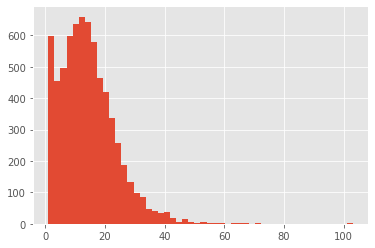

max len:  103


In [16]:
getter = SentenceGetter(DATA_TESTED)
sent = getter.get_next()
# print(sent)
sentences = getter.sentences
print("no. of sentencces: " +str(len(sentences)))

import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

print("max len: ",max([len(s) for s in sentences]))

In [58]:
from keras.preprocessing.sequence import pad_sequences

WORD_PAD = "WORDPAD"
POS_PAD = "POSPAD"
SHAPE_PAD = "SHAPEPAD"

words = list(set(DATA_TESTED[TOKEN_COL].values))
words.append(WORD_PAD)
tags = list(set(DATA_TESTED[NER_COL].values))
pos = list(set(DATA_TESTED[POS_COL].values))
pos.append(POS_PAD)
shape = list(set(DATA_TESTED[SHAPE_COL].values))
shape.append(SHAPE_PAD)
n_words = len(words)
n_tags = len(tags)
n_pos = len(pos)
n_shape = len(shape)
print(n_pos)
# MAX_LEN = max([len(s) for s in sentences])
MAX_LEN = 80
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
pos2idx = {t: i for i, t in enumerate(pos)}
shape2idx = {t: i for i, t in enumerate(shape)}
# print(word2idx["i"])
print(tag2idx)
print(pos2idx)
print(shape2idx)



# n_words = len(words); n_words

from keras.utils import to_categorical

# X_word = [[word2idx[w[0]] for w in s] for s in sentences]
# X_shape = [[shape2idx[w[3]] for w in s] for s in sentences]
# X_pos = [[pos2idx[w[1]] for w in s] for s in sentences]
# y = [[tag2idx[w[2]] for w in s] for s in sentences]

X_sent_nr = DATA_TESTED[SENT_COL].values
X_word = [word2idx[w] for w in DATA_TESTED[TOKEN_COL].values]
X_shape = [shape2idx[w] for w in DATA_TESTED[SHAPE_COL].values]
X_pos = [pos2idx[w] for w in DATA_TESTED[POS_COL].values]
y = [tag2idx[w] for w in DATA_TESTED[NER_COL].values]
y = [to_categorical(i, num_classes=n_tags) for i in y]

def limitSentenceLength( arrays, max_len):
    newArrays = []
    for sent_array in arrays:
        if(len(sent_array)>max_len):
            newArrays.append(sent_array[:max_len])
        else:
            newArrays.append(sent_array)
    return newArrays

#Limit sentence to MAX_LEN
# y = limitSentenceLength(y, MAX_LEN)
# X_word = limitSentenceLength(X_word, MAX_LEN)
# X_pos = limitSentenceLength(X_pos, MAX_LEN)
# X_shape = limitSentenceLength(X_shape, MAX_LEN)

#Pad to MAX_LEN
# y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["O"])
# X_word = pad_sequences(maxlen=MAX_LEN, sequences=X_word, padding="post", value=n_words - 1)
# X_pos = pad_sequences(maxlen=MAX_LEN, sequences=X_pos, padding="post", value=n_pos - 1)
# X_shape = pad_sequences(maxlen=MAX_LEN, sequences=X_pos, padding="post", value=n_pos - 1)

# y = [to_categorical(i, num_classes=n_tags) for i in y]

# X = np.column_stack((X_word,X_pos,X_shape))

26
{'LOC': 0, 'PRS': 1, 'ORG': 2, 'O': 3, 'OTHER': 4}
{'PN': 0, 'DT': 1, 'MAD': 2, 'IE': 3, 'IN': 4, 'PC': 5, 'HP': 6, 'JJ': 7, 'RO': 8, 'HD': 9, 'VB': 10, 'NN': 11, 'MID': 12, 'HS': 13, 'AB': 14, 'RG': 15, 'PS': 16, 'HA': 17, 'PAD': 18, 'PP': 19, 'PL': 20, 'UO': 21, 'SN': 22, 'PM': 23, 'KN': 24, 'POSPAD': 25}
{'X.': 0, 'x.': 1, 'sign': 2, 'X': 3, 'Xx': 4, 'x': 5, 'SHAPEPAD': 6}


In [59]:
# X_sent_nr = DATA_TESTED[SENT_COL].values
# X_word = [word2idx[w] for w in DATA_TESTED[TOKEN_COL].values]
# X_shape = [shape2idx[w] for w in DATA_TESTED[SHAPE_COL].values]
# X_pos = [pos2idx[w] for w in DATA_TESTED[POS_COL].values]
# y = [tag2idx[w] for w in DATA_TESTED[NER_COL].values]
HISTORY_LIMIT = 3 # looking N-1 in both directions

def getSentLimit(sent_nr_array,i):
    currentSentId = sent_nr_array[i]
    limitPrev=0
    limitNext=0
    for j in range(HISTORY_LIMIT):
        if j == 0 :
            continue
        if i-j>=0 and sent_nr_array[i-j] == currentSentId:
            limitPrev = j
        if i+j<len(sent_nr_array) and sent_nr_array[i+j] == currentSentId:
            limitNext = j
    
    return limitPrev, limitNext


newX = []

# word2idx = {w: i for i, w in enumerate(words)}
# tag2idx = {t: i for i, t in enumerate(tags)}
# pos2idx = {t: i for i, t in enumerate(pos)}
# shape2idx = {t: i for i, t in enumerate(shape)}
X_features = [X_word,X_shape,X_pos]
featurePad = [word2idx[WORD_PAD],pos2idx[POS_PAD],shape2idx[SHAPE_PAD]]

# y = []
for i in range(len(X_sent_nr)):
    limitPrev, limitNext = getSentLimit(X_sent_nr,i)
    
    X_feature_row =  []
    
    for featId in range(len(X_features)):
        X_feature_row.append(X_features[featId][i])
    
    for j in range(HISTORY_LIMIT):
        if j == 0 :
            continue
        for featId in range(len(X_features)):
            featureList = X_features[featId]
            if j<=limitPrev:
                X_feature_row.append(featureList[i-j])
            else:
                X_feature_row.append(featurePad[featId])
            if j<=limitNext:
                X_feature_row.append(featureList[i+j])
            else:
                X_feature_row.append(featurePad[featId])
    newX.append(X_feature_row)
print(newX[0])

inputLen = len(newX[0])
print("inputLen: "+ str(inputLen))


print(y[0])
X_tr, X_te, y_tr, y_te = train_test_split(newX, y, test_size=0.1)
print(y[0])
print(np.array(y_tr)[0])

[6904, 3, 19, 19371, 765, 25, 5, 6, 16, 19371, 17148, 25, 5, 6, 8]
inputLen: 15
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]


In [ ]:
# from sklearn.model_selection import train_test_split

# from keras.models import Model, Input
# from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
# from keras.models import Sequential

# input1 = Input(shape=(MAX_LEN*3,))
# # # word_emb = Embedding(input_dim=n_words + 1, output_dim=80, input_length=MAX_LEN, mask_zero=True)(input)

# # # input2 = Input(shape=(MAX_LEN,))
# # # pos_emb = Embedding(input_dim=n_pos, output_dim=80, input_length=MAX_LEN, mask_zero=True)(input2)
# # # concate_layers = keras.layers.concatenate([word_emb, pos_emb],axis=1)
model = Sequential()
# # model = Sequential()
# # # model.add(Bidirectional(LSTM(num_channels, 
# # #                                      implementation = 2, recurrent_activation = 'sigmoid'),
# # #                                 input_shape=(input_length, input_dim)))

model.add(Dense(inputLen*2, activation='relu', input_dim=inputLen))
model.add(Dense(n_tags, activation='sigmoid'))

# # main_input = Input(shape=(MAX_LEN,))
# # word_emb = Embedding(input_dim=n_words + 1, output_dim=150,input_length=MAX_LEN, mask_zero=True)(main_input)

# # input2 = Input(shape=(MAX_LEN,))
# # posd_emb = Embedding(input_dim=n_pos, output_dim=150,input_length=MAX_LEN, mask_zero=True)(input2)

# # concat_layer = keras.layers.concatenate([word_emb, posd_emb],axis=1)

# # model = Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.1))(concat_layer)

# word_input = Input(shape=(MAX_LEN,))
# word_emb = Embedding(input_dim=n_words + 1, output_dim=20, input_length=MAX_LEN, mask_zero=True)(word_input)
# model = Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.1))(word_emb)
# out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer
# model = Model(inputs=[word_input], outputs=[out])

# pos_input = Input(shape=(MAX_LEN,))
# pos_emb = Embedding(input_dim=n_words + 1, output_dim=20, input_length=MAX_LEN, mask_zero=True)(pos_input)
# model2 = Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.1))(pos_emb)
# out2 = TimeDistributed(Dense(n_tags, activation="softmax"))(model2)  # softmax output layer
# model2 = Model(inputs=[pos_input], outputs=[out2])

# from keras.layers import Add
# mergedOut = Add()([model.output,model2.output])
# newModel = Model([word_input,pos_input], mergedOut)


# # pos_input = Input(shape=(MAX_LEN,))
# # pos_emb = Embedding(input_dim=n_pos, output_dim=10, input_length=MAX_LEN, mask_zero=True)(pos_input)

# # model = keras.layers.concatenate([word_emb, pos_emb])

# # # model = keras.layers.Concatenate([word, pos])

# # # model1 = Embedding(input_dim=n_words, output_dim=50, input_length=MAX_LEN*2)(concate_layers)
# # # model1 = Dropout(0.1)(concate_layers)
# # # model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
# # # model = Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.1))(model)
# # # model2 = Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.1))(model1)
# # # model = Model(input, out)
# # model = Model(inputs=[main_input,input2], outputs=out)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy",tf.keras.metrics.Recall()])


# newModel.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
# # # model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=[tf.keras.metrics.Recall()])
# # print("compiled")
# # print(len(X_tr[0]))

# X_tr_wrd = []
# X_tr_pos = []
# for array in X_tr:
# #     print(len(array))
# #     print(len(array[:MAX_LEN]))
# #     print(len(array[MAX_LEN:]))
#     X_tr_wrd.append(array[:MAX_LEN])
#     X_tr_pos.append(array[MAX_LEN:-MAX_LEN])
# print(X_tr[0])
# # print(y_tr[0])
model.summary()
# y_tr_tmp=[]
# y_tr_tmp.append(y_tr)
# y_tr_tmp.append(y_tr)
# # y_tr_tmp.append(y_tr)
# # print(np.array(y_tr_tmp)[0])

history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=3, validation_split=0.1, verbose=1)

In [ ]:

# #y = [to_categorical(i, num_classes=n_tags) for i in y]
# from sklearn.model_selection import train_test_split
# X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
# from keras.models import Model, Input
# from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
# input = Input(shape=(inputDim,))
# model = Embedding(input_dim=n_words, output_dim=50, input_length=inputDim)(input)
# model = Dropout(0.1)(model)
# model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
# out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer
# model = Model(input, out)
# model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy",tf.keras.metrics.Recall()])
# print("compiled")
# print(len(X_tr[0]))
# history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=1, validation_split=0.1, verbose=1)

In [ ]:
# #Working
# hist = pd.DataFrame(history.history)
# plt.figure(figsize=(12,12))
# plt.plot(hist["accuracy"])
# plt.plot(hist["val_accuracy"])
# plt.show()

In [19]:
# from sklearn_crfsuite import CRF

# crf = CRF(algorithm='lbfgs',
#           c1=0.1,
#           c2=0.1,
#           max_iterations=100,
#           all_possible_transitions=False)
# pred = cross_val_predict(estimator=crf, X=X, y=y, cv=5)
from sklearn_crfsuite.metrics import flat_classification_report
# report = flat_classification_report(y_pred=pred, y_true=y)
# print(report)
# crf.fit(X, y)
pred = newModel.predict([X_tr_wrd,X_tr_pos])
#print(pred)
print(len(pred))
# print(pred)
pred = [[ np.argmax(row) for row in tmp] for tmp in pred ]
# print(pred)
# pred = cross_val_predict(estimator=crf, X=X, y=y, cv=5)
# print(pred[0])
# print(y_te[0][0])
# pred2 = [to_categorical(i, num_classes=n_tags) for i in pred]
# print(pred2[0][0])

# print(len(y_te))
# print(len(pred))
# print(len(y_te[22]))
# print(len(pred[22]))


y_tr_real = []
count_y = 0
count_p = 0
for sent_array in y_tr:
    for array in sent_array:
        nerTag = np.argmax(array)
        found = 0
        for tag in tag2idx:
            if nerTag == tag2idx[tag]:
                count_y = count_y+1
                found=1
                y_tr_real.append(tag)
                break
        if found == 0:
            raise Exception("found is 0")
# print(y_te_real)
pred_real = []
for sent_array in pred:
    for guess in sent_array:
        nerTag = guess
#         print(guess)
        found = 0
        for tag in tag2idx:
#         print(nerTag)
            if nerTag == tag2idx[tag]:
                count_p = count_p+1
                found=1
                pred_real.append(tag)
                break
        if found == 0:
            raise Exception("found is 0")
#     y_te_real.append()
# print(count_y)
# print(count_p)
# print(len((pred_real)))
#print(len(flatten(y_te_real)))
# y_te_real = np.matrix(y_te_real)
# pred_real = np.matrix(pred_real)
# print(pred_real)

report = classification_report(y_pred=pred_real, y_true=y_tr_real)
print(report)

6175


/home/ken/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         LOC       0.00      0.00      0.00      2036
           O       0.99      1.00      0.99    486984
         ORG       0.00      0.00      0.00      1099
       OTHER       0.00      0.00      0.00       476
         PRS       0.00      0.00      0.00      3405

    accuracy                           0.99    494000
   macro avg       0.20      0.20      0.20    494000
weighted avg       0.97      0.99      0.98    494000



In [ ]:
# i = 2
# p = model.predict(np.array([X_te[i]]))
# p = np.argmax(p, axis=-1)
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
# for w, pred in zip(X_te[i], p[0]):
#     print("{:15}: {}".format(words[w], tags[pred]))



#### Train Model

#### Test Accuracy

In [ ]:
# results = model.evaluate(xTest,yTest, verbose=0)
# results = model.evaluate(X_te,y_te, verbose=1)
# print('test loss, test acc, test recall:', results)
# X_tr, X_te, y_tr, y_te
#Only Acc, 142, 7000, feat:1,2,-1 : [0.22299354140212138, 0.9714275]
#[0.2284703826159239, 0.9709106, 0.92750543]
#Recall [0.22716047498087089, 0.9273468]

# 142, standardized [0.16994940752536059, 0.9674706, 0.9300009]


#### Save Model

In [ ]:
#https://github.com/floydhub/named-entity-recognition-template/blob/master/ner.ipynb
# Saving Vocab
#with open('models/word_to_index.pickle', 'wb') as handle:
#    pickle.dump(word2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)
 
# Saving Vocab
#with open('models/tag_to_index.pickle', 'wb') as handle:
#    pickle.dump(tag2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# Saving Model Weight
#model.save_weights('models/lstm_crf_weights.h5')